In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

   censoring_threshold Architecture Class  Train Loss  Dev Loss  Test Loss                                                                                                                                                                                                    path  Test Gap %  Learning Rate
0                    6            Vanilla    4.091292  4.089784   4.404447                                  /user/ml4723/Prj/NIC/ray_results/one_store_lost_demands_censored/vanilla/run_2024-12-12_15-58-21/run_d1e4c_00008_8_censoring_threshold=6,samples=3_2024-12-12_15-58-21    0.000000            NaN
0                    6  Capped Base Stock    4.104241  4.100473   4.433359   /user/ml4723/Prj/NIC/ray_results/one_store_lost_demands_censored/capped_base_stock/run_2024-12-12_16-00-02/run_0e858_00000_0_censoring_threshold=6,learning_rate=0.1000,samples=1_2024-12-12_16-00-03    0.656429            0.1
0                    7            Vanilla    4.253151  4.244869   4.403279                    

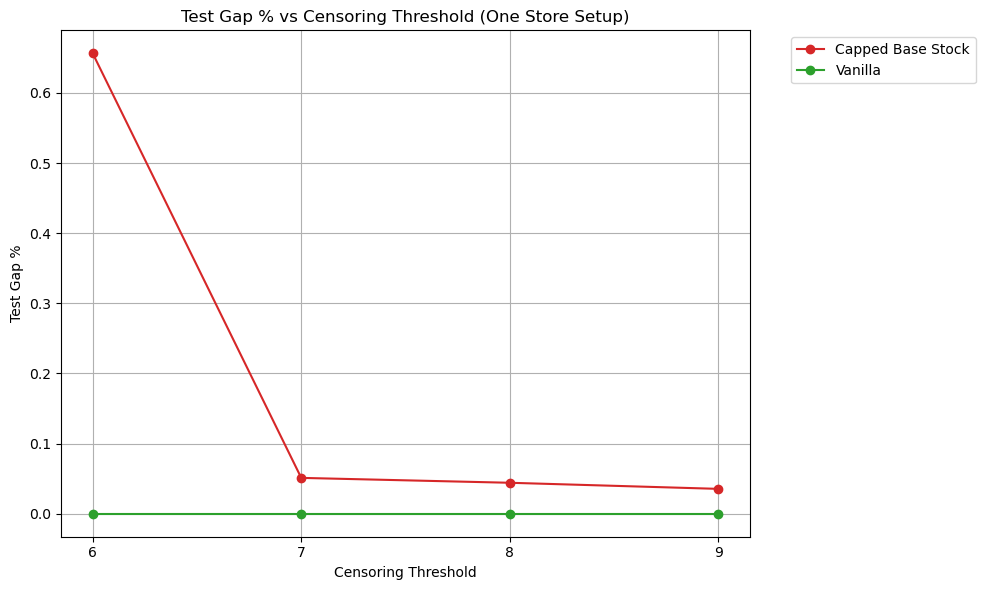

In [2]:
# Define color scheme for architecture types
color_scheme = {
    "Vanilla": "#2ca02c",  # Green
    "Capped Base Stock": "#d62728",  # Red
}

linestyle_scheme = {
    "Vanilla": "-",  # Solid
    "Capped Base Stock": "-",  # Solid
}

path = 'one_store_lost_demands_censored'
vanilla_paths = {
    1: f'/user/ml4723/Prj/NIC/ray_results/{path}/vanilla/'
}

capped_base_stock_paths = {
    1: f'/user/ml4723/Prj/NIC/ray_results/{path}/capped_base_stock/',
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'test_loss'
pick_row_from_run_by = 'test_loss'

results_interpretor = rri.RayResultsinterpreter()

dfs = []
for censoring_threshold in [6, 7, 8, 9]:
    # Vanilla for this threshold
    df_vanilla = results_interpretor.make_table(vanilla_paths,
        {'censoring_threshold': [censoring_threshold]},
        default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
    df_vanilla.insert(2, 'Architecture Class', "Vanilla")
    df_vanilla.insert(1, 'hyperparam_name', "vanilla_one_store")
    df_vanilla['Censoring Threshold'] = censoring_threshold
    
    # Capped Base Stock for this threshold
    df_capped = results_interpretor.make_table(capped_base_stock_paths,
        {'censoring_threshold': [censoring_threshold]},
        default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
    df_capped.insert(2, 'Architecture Class', "Capped Base Stock")
    df_capped.insert(1, 'hyperparam_name', "capped_base_stock")
    df_capped['Censoring Threshold'] = censoring_threshold
    
    dfs.extend([df_vanilla, df_capped])

# Combine all dataframes
df = pd.concat(dfs)

min_test_loss = df.groupby(['Censoring Threshold'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['Censoring Threshold'], inplace=True)

# Print formatted table
df_to_print = df.copy()
columns_to_drop = ['hyperparam_name', '# of runs', 'Censoring Threshold', '# of stores']
df_to_print.drop(columns=[col for col in columns_to_drop if col in df_to_print.columns], inplace=True)
print(df_to_print.to_string())

# Create single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create pivot table
pivot_df = df.groupby(['Censoring Threshold', 'Architecture Class'])['Test Gap %'].mean().unstack()

# Plot lines for each architecture
for column in pivot_df.columns:
    ax.plot(pivot_df.index, pivot_df[column],
            marker='o',
            label=column,
            color=color_scheme[column],
            linestyle=linestyle_scheme[column])

ax.set_xlabel('Censoring Threshold')
ax.set_ylabel('Test Gap %')
ax.set_title('Test Gap % vs Censoring Threshold (One Store Setup)')
ax.grid(True)
ax.set_xticks(pivot_df.index)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()